## I played around with trying to look at diff QC metrics, but data looks processed in some way. Low MT%, etc etc. Can jsut skip this

In [20]:
# Per-Experiment Preprocessing vs Global Approach

# 1. **Current Global Approach**: Download → ...
# 2. **Per-Experiment Approach**: QC + Filter per experiment → Remove Batch effects → ...

# Normalize read counts per UMI?

# - Experiment-specific quality control (mitochondrial %, UMI counts)
# - Per-experiment normalization using scran

# Task: Created data that is qc'ed

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import json
import h5py
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import warnings
import logging
from collections import defaultdict

# Configure scanpy
sc.settings.verbosity = 1  # Reduce verbosity
# sc.settings.set_figure_params(dpi=80, facecolor='white')

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Configuration
DATA_DIR = Path("/vcc/data/scRNA/processed")
QCED_DIR = Path("/vcc/data/scRNA/MT_BATCH_QCED")
QCED_DIR.mkdir(parents=True, exist_ok=True)

In [21]:
# Memory-efficient streaming loader
import time
import gc

def load_single_file_streaming(file_path: Path, chunk_size: int = 10000) -> sc.AnnData:
    """
    Load a single H5 file using streaming/chunked approach to handle large files.
    
    Args:
        file_path: Path to H5 file
        chunk_size: Number of cells to process at once
    
    Returns:
        AnnData object
    """
    logger.info(f"Streaming load: {file_path.name}")
    start_time = time.time()
    
    with h5py.File(file_path, 'r') as f:
        # Get file info first
        n_cells, n_genes = f['X'].shape
        file_size_mb = file_path.stat().st_size / 1024 / 1024
        
        logger.info(f"  File: {file_size_mb:.1f}MB")
        logger.info(f"  Matrix: {n_cells:,} cells x {n_genes:,} genes")
        logger.info(f"  Chunk size: {chunk_size:,} cells")
        
        # Load metadata first (small and fast)
        logger.info("  Loading metadata...")
        genes_raw = f['genes'][:]
        cells_raw = f['cells'][:]
        
        # Decode strings efficiently
        genes = [g.decode('utf-8') if isinstance(g, bytes) else str(g) for g in genes_raw]
        cells = [c.decode('utf-8') if isinstance(c, bytes) else str(c) for c in cells_raw]
        
        logger.info("  Processing expression matrix in chunks...")
        
        # Process matrix in chunks to avoid memory overload
        X_chunks = []
        n_chunks = (n_cells + chunk_size - 1) // chunk_size
        
        for i in range(0, n_cells, chunk_size):
            chunk_idx = i // chunk_size + 1
            end_idx = min(i + chunk_size, n_cells)
            
            logger.info(f"    Chunk {chunk_idx}/{n_chunks}: cells {i:,}-{end_idx:,}")
            
            # Load chunk
            chunk_start = time.time()
            X_chunk = f['X'][i:end_idx, :]
            
            # Convert to sparse immediately
            import scipy.sparse as sp
            if not sp.issparse(X_chunk):
                X_chunk_sparse = sp.csr_matrix(X_chunk)
            else:
                X_chunk_sparse = X_chunk
            
            X_chunks.append(X_chunk_sparse)
            
            chunk_time = time.time() - chunk_start
            logger.info(f"      Processed in {chunk_time:.2f}s")
            
            # Force garbage collection after each chunk
            if chunk_idx % 5 == 0:
                gc.collect()
        
        # Combine chunks
        logger.info("  Combining chunks...")
        combine_start = time.time()
        
        import scipy.sparse as sp
        X_combined = sp.vstack(X_chunks)
        
        # Clear chunk memory
        del X_chunks
        gc.collect()
        
        combine_time = time.time() - combine_start
        logger.info(f"  Combined in {combine_time:.2f}s")
        
        # Create AnnData
        logger.info("  Creating AnnData...")
        adata = sc.AnnData(X=X_combined)
        adata.var_names = genes
        adata.obs_names = cells
        
        # Load obs metadata if available
        if 'obs' in f:
            logger.info("  Loading cell metadata...")
            for key in f['obs'].keys():
                data = f['obs'][key][:]
                if data.dtype.kind == 'S':
                    data = [d.decode('utf-8') if isinstance(d, bytes) else str(d) for d in data]
                adata.obs[key] = data
        
        # Final statistics
        sparsity = 1 - (X_combined.nnz / (X_combined.shape[0] * X_combined.shape[1]))
        mem_mb = (X_combined.data.nbytes + X_combined.indices.nbytes + X_combined.indptr.nbytes) / 1024 / 1024
        
        total_time = time.time() - start_time
        logger.info(f"  ✅ Streaming load complete!")
        logger.info(f"     Time: {total_time:.2f}s")
        logger.info(f"     Sparsity: {sparsity:.1%}")
        logger.info(f"     Memory: {mem_mb:.1f}MB")
        logger.info(f"     Speed: {n_cells/total_time:.0f} cells/sec")
    
    return adata

def diagnose_file_structure(file_path: Path):
    """Diagnose what's inside an H5 file without loading large arrays."""
    logger.info(f"Diagnosing {file_path.name}...")
    
    with h5py.File(file_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                logger.info(f"  {name}: {obj.shape} {obj.dtype}")
            else:
                logger.info(f"  {name}/")
        
        f.visititems(print_structure)
        
        # Test reading a small sample
        if 'X' in f:
            logger.info("\\n  Testing small sample read...")
            try:
                sample = f['X'][:10, :10]  # Just 10x10 sample
                logger.info(f"  Sample shape: {sample.shape}")
                logger.info(f"  Sample dtype: {sample.dtype}")
                logger.info(f"  Sample max: {sample.max()}")
                logger.info(f"  Sample nonzero: {(sample > 0).sum()}/{sample.size}")
            except Exception as e:
                logger.error(f"  Error reading sample: {e}")

# Test the problematic file
problem_file = DATA_DIR / "batch_0000.h5"

logger.info("="*50)
logger.info("DIAGNOSING FILE STRUCTURE")
logger.info("="*50)

diagnose_file_structure(problem_file)

logger.info("\\n" + "="*50)
logger.info("TESTING STREAMING LOADER")
logger.info("="*50)

try:
    # Try loading with streaming approach
    adata = load_single_file_streaming(problem_file, chunk_size=5000)
    logger.info(f"\\n✅ SUCCESS! Loaded {adata.shape} with streaming approach")
    
    # Quick validation
    logger.info("\\nQuick validation:")
    logger.info(f"  Max expression: {adata.X.max()}")
    logger.info(f"  Mean cells per gene: {(adata.X > 0).sum(0).mean():.1f}")
    logger.info(f"  Mean genes per cell: {(adata.X > 0).sum(1).mean():.1f}")
    
except Exception as e:
    logger.error(f"❌ Streaming loader failed: {e}")
    import traceback
    traceback.print_exc()

INFO:__main__:==================================================
INFO:__main__:DIAGNOSING FILE STRUCTURE
INFO:__main__:==================================================
INFO:__main__:Diagnosing batch_0000.h5...
INFO:__main__:  X: (71172, 36601) int32
INFO:__main__:  cells: (71172,) |S16
INFO:__main__:  genes: (36601,) |S15
INFO:__main__:DIAGNOSING FILE STRUCTURE
INFO:__main__:==================================================
INFO:__main__:Diagnosing batch_0000.h5...
INFO:__main__:  X: (71172, 36601) int32
INFO:__main__:  cells: (71172,) |S16
INFO:__main__:  genes: (36601,) |S15
INFO:__main__:  obs/
INFO:__main__:  obs/SRX_accession: (71172,) |S11
INFO:__main__:  obs/gene_count: (71172,) int64
INFO:__main__:  obs/umi_count: (71172,) float32
INFO:__main__:\n  Testing small sample read...
INFO:__main__:  Sample shape: (10, 10)
INFO:__main__:  Sample dtype: int32
INFO:__main__:  Sample max: 0
INFO:__main__:  Sample nonzero: 0/100
INFO:__main__:\n==========================================

In [22]:
# Fix gene annotation - convert Ensembl IDs to gene symbols for proper MT/Ribo detection
print("Sample of current gene IDs:")
print(adata.var_names[:10].tolist())
print(f"\nTotal genes: {len(adata.var_names)}")

# Option 1: Use biomart/mygene to convert Ensembl IDs to gene symbols
# Option 2: Use known mitochondrial Ensembl IDs 
# Option 3: Download reference annotation

# Let's try using mygene for ID conversion
try:
    import mygene
    mg = mygene.MyGeneInfo()
    
    print("\n🔄 Converting Ensembl IDs to gene symbols...")
    
    # Convert in batches to avoid API limits
    batch_size = 1000
    gene_mapping = {}
    
    for i in range(0, len(adata.var_names), batch_size):
        batch = adata.var_names[i:i+batch_size].tolist()
        print(f"  Processing batch {i//batch_size + 1}/{(len(adata.var_names) + batch_size - 1)//batch_size}")
        
        try:
            result = mg.querymany(batch, scopes='ensembl.gene', fields='symbol', species='human', verbose=False)
            for item in result:
                if 'symbol' in item and 'query' in item:
                    gene_mapping[item['query']] = item['symbol']
        except Exception as e:
            print(f"    Batch failed: {e}")
            continue
    
    print(f"✅ Mapped {len(gene_mapping)} genes to symbols")
    
    # Add gene symbols to adata.var
    adata.var['gene_symbol'] = [gene_mapping.get(ensembl_id, ensembl_id) for ensembl_id in adata.var_names]
    
    # Now properly identify MT and Ribo genes using symbols
    adata.var["mt"] = adata.var['gene_symbol'].str.startswith("MT-")
    adata.var["ribo"] = adata.var['gene_symbol'].str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var['gene_symbol'].str.contains("^HB[^(P)]")
    
    print(f"✅ Found {adata.var['mt'].sum()} mitochondrial genes")
    print(f"✅ Found {adata.var['ribo'].sum()} ribosomal genes") 
    print(f"✅ Found {adata.var['hb'].sum()} hemoglobin genes")
    
    if adata.var['mt'].sum() > 0:
        print("Sample MT genes:", adata.var[adata.var['mt']]['gene_symbol'].head().tolist())
    if adata.var['ribo'].sum() > 0:
        print("Sample Ribo genes:", adata.var[adata.var['ribo']]['gene_symbol'].head().tolist())

except ImportError:
    print("❌ mygene not installed. Installing...")
    import subprocess
    subprocess.run(["pip", "install", "mygene"], check=True)
    print("✅ mygene installed. Please re-run this cell.")
    
except Exception as e:
    print(f"❌ Gene conversion failed: {e}")
    print("🔄 Falling back to known mitochondrial Ensembl IDs...")
    
    # Fallback: Use known human mitochondrial gene Ensembl IDs
    # These are the 37 protein-coding mitochondrial genes in humans
    mt_ensembl_ids = {
        'ENSG00000198888',  # MT-ND1
        'ENSG00000198763',  # MT-ND2  
        'ENSG00000198804',  # MT-CO1
        'ENSG00000198712',  # MT-CO2
        'ENSG00000198899',  # MT-ATP8
        'ENSG00000198938',  # MT-ATP6
        'ENSG00000198840',  # MT-CO3
        'ENSG00000212907',  # MT-ND3
        'ENSG00000198886',  # MT-ND4L
        'ENSG00000198786',  # MT-ND4
        'ENSG00000198695',  # MT-ND5
        'ENSG00000198727',  # MT-ND6
        'ENSG00000198938',  # MT-CYB
        # Add rRNA and tRNA genes
        'ENSG00000211459',  # MT-RNR1 (12S rRNA)
        'ENSG00000210077',  # MT-RNR2 (16S rRNA)
        # tRNA genes (22 of them)
        'ENSG00000210049', 'ENSG00000209082', 'ENSG00000198888', 'ENSG00000210077',
        'ENSG00000210082', 'ENSG00000209079', 'ENSG00000198763', 'ENSG00000210154',
        'ENSG00000210156', 'ENSG00000210164', 'ENSG00000210174', 'ENSG00000210176',
        'ENSG00000210184', 'ENSG00000210191', 'ENSG00000210194', 'ENSG00000210195',
        'ENSG00000210196', 'ENSG00000198804', 'ENSG00000210127', 'ENSG00000210135',
        'ENSG00000210140', 'ENSG00000210144'
    }
    
    adata.var["mt"] = adata.var_names.isin(mt_ensembl_ids)
    
    # For ribosomal genes, we need to be more clever
    # We can look for genes that have high expression correlation patterns typical of ribosomal genes
    # Or use partial matching if some gene symbols are mixed in
    adata.var["ribo"] = adata.var_names.str.contains("RPS|RPL", case=False)
    adata.var["hb"] = adata.var_names.str.contains("HB", case=False)
    
    print(f"✅ Fallback: Found {adata.var['mt'].sum()} mitochondrial genes")
    print(f"✅ Fallback: Found {adata.var['ribo'].sum()} ribosomal genes") 
    print(f"✅ Fallback: Found {adata.var['hb'].sum()} hemoglobin genes")

Sample of current gene IDs:
['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448', 'ENSG00000236601']

Total genes: 36601

🔄 Converting Ensembl IDs to gene symbols...
  Processing batch 1/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 2/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 3/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 4/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 5/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 6/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 7/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 8/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 9/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 10/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 11/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 12/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 13/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 14/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 15/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 16/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 17/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 18/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 19/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 20/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 21/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 22/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 23/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 24/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 25/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 26/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 27/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 28/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 29/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 30/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 31/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 32/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 33/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 34/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 35/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 36/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


  Processing batch 37/37


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"


✅ Mapped 26640 genes to symbols
✅ Found 13 mitochondrial genes
✅ Found 109 ribosomal genes
✅ Found 12 hemoglobin genes
Sample MT genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8']
Sample Ribo genes: ['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5']


In [23]:
adata_org = adata.copy()
# adata = adata[adata.obs['SRX_accession'] == 'ERX11467034'].copy()

# Analyze the sample in depth

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


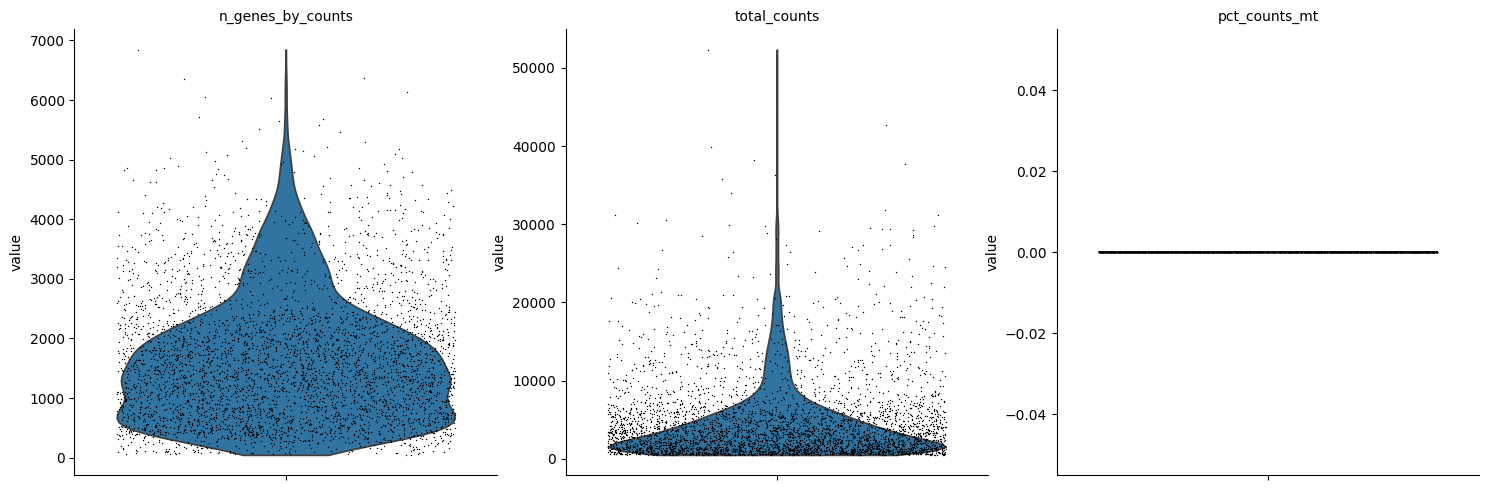

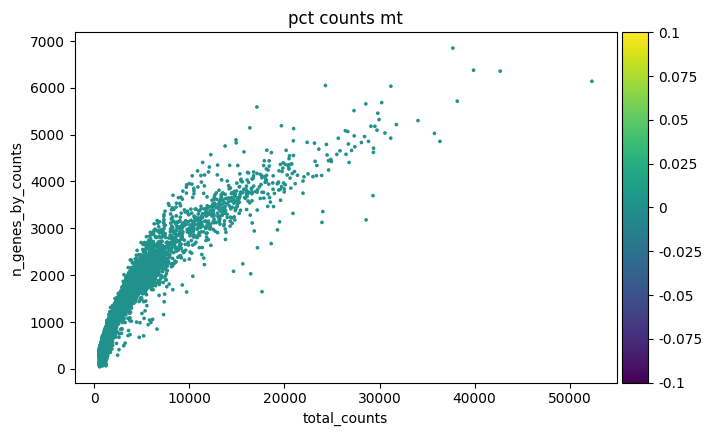

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


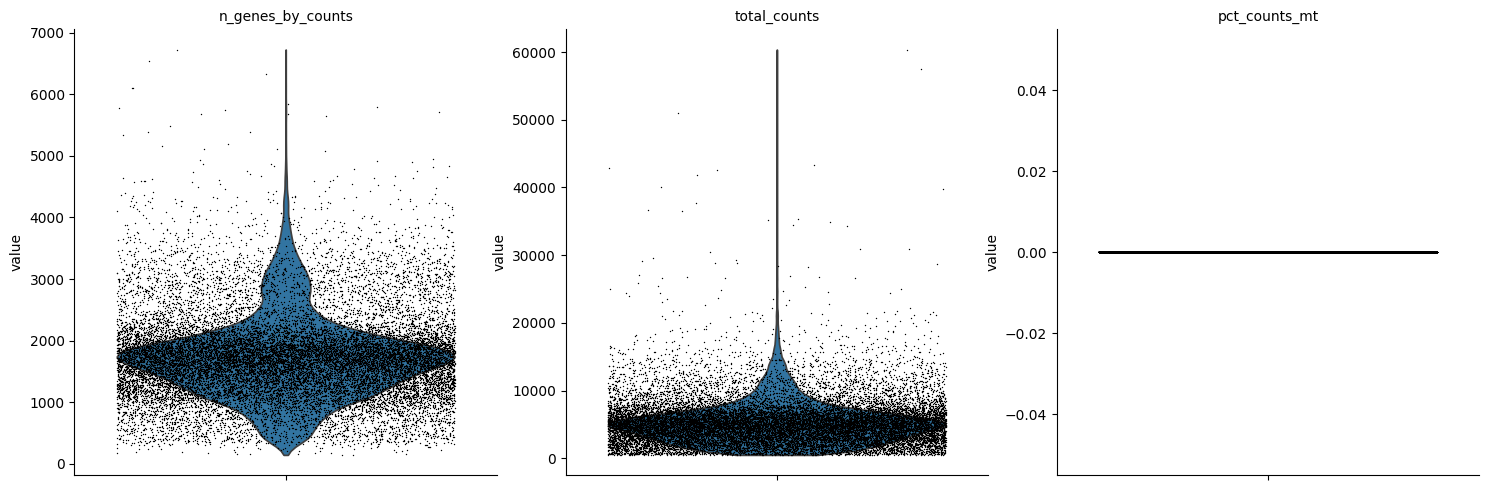

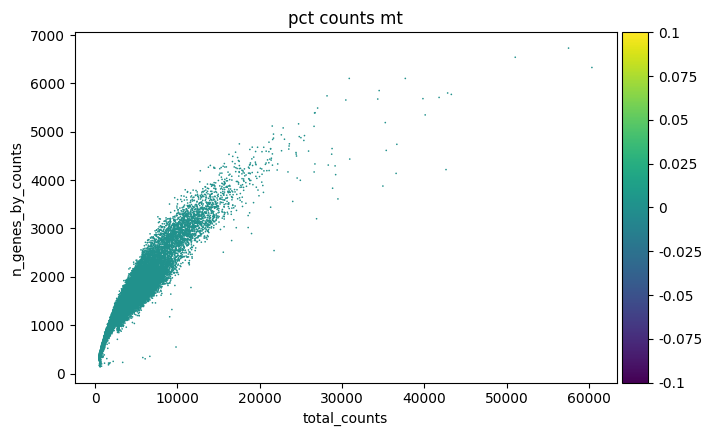

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


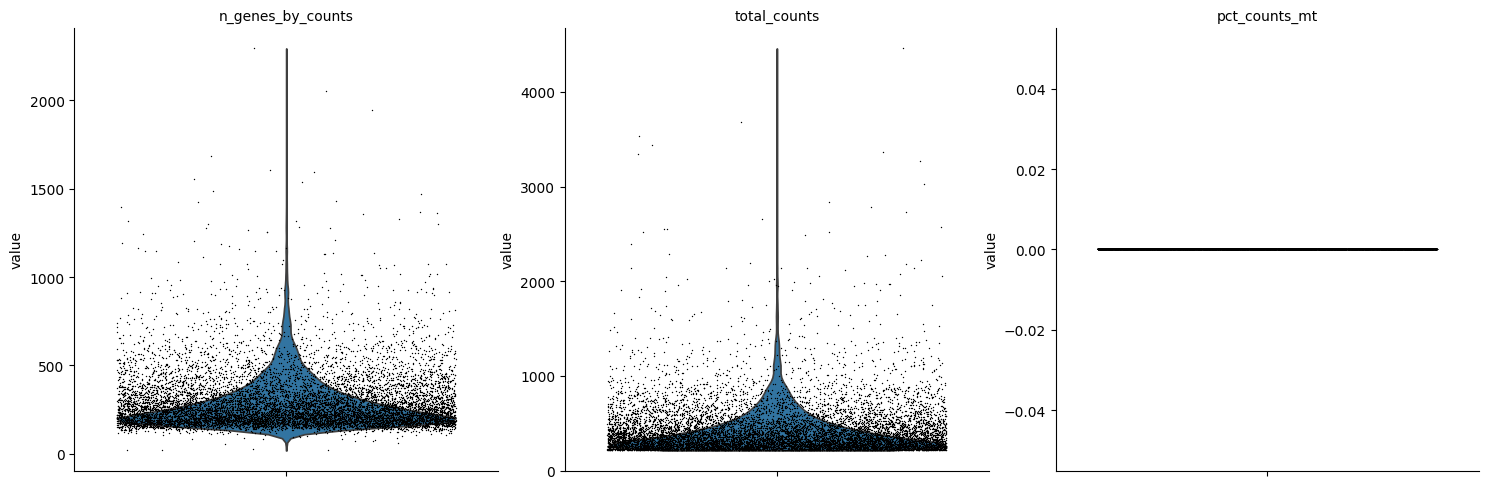

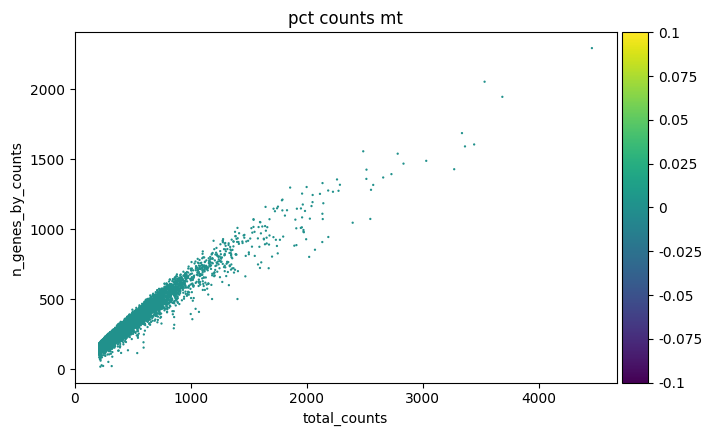

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


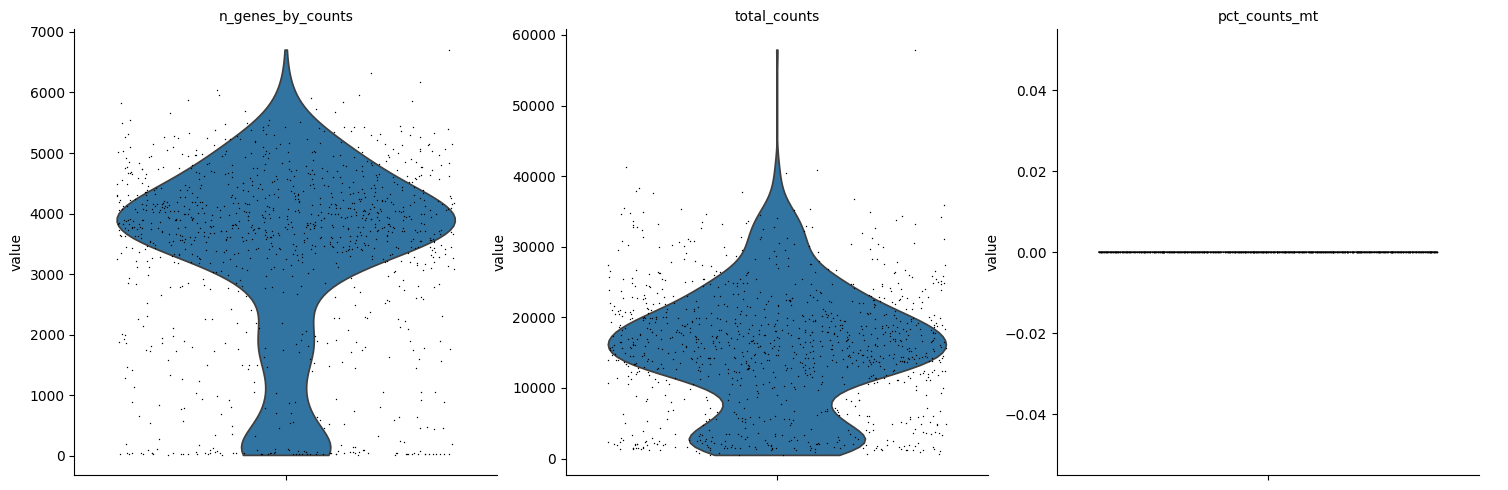

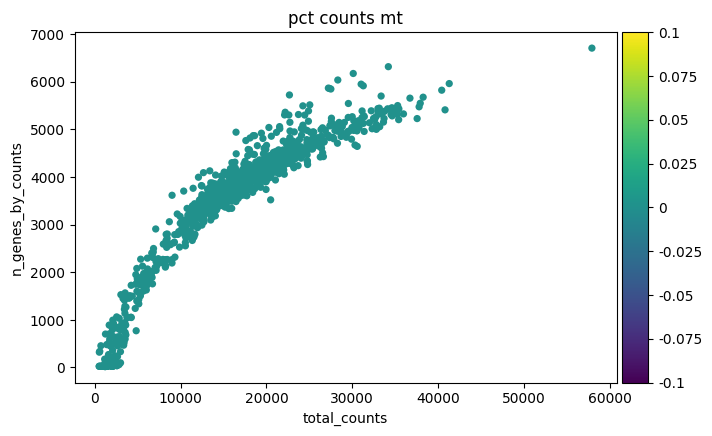

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


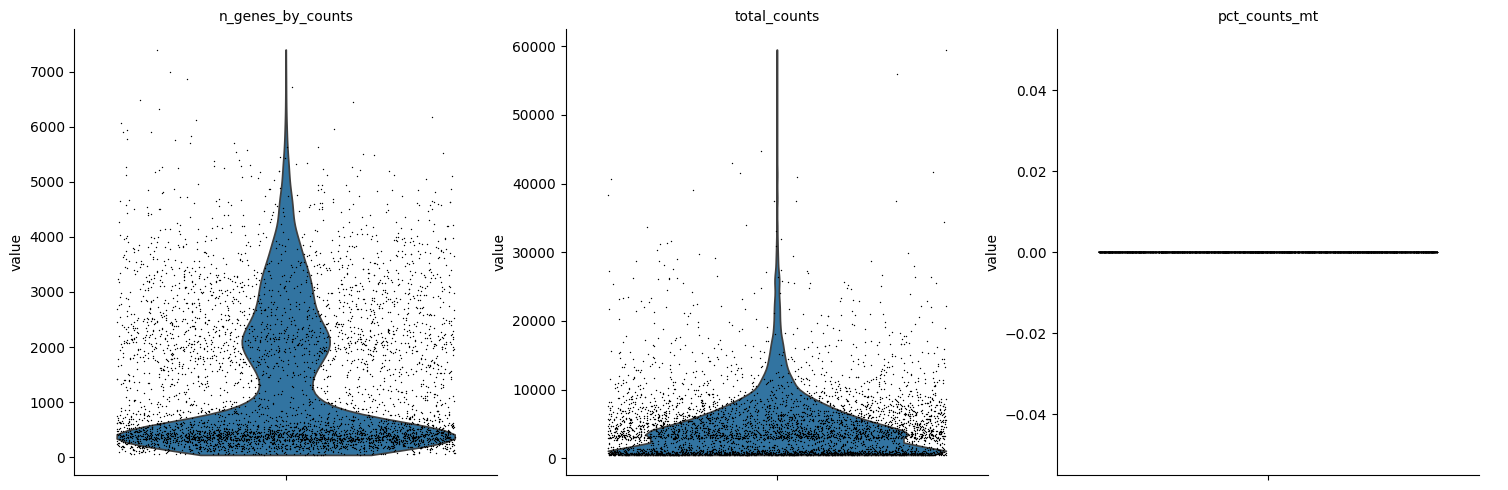

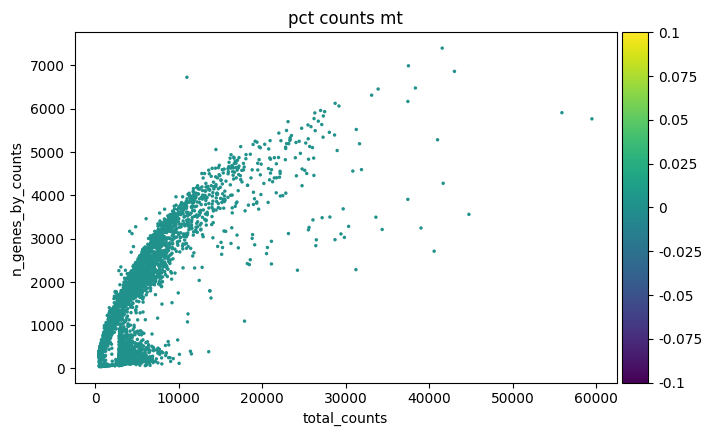

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


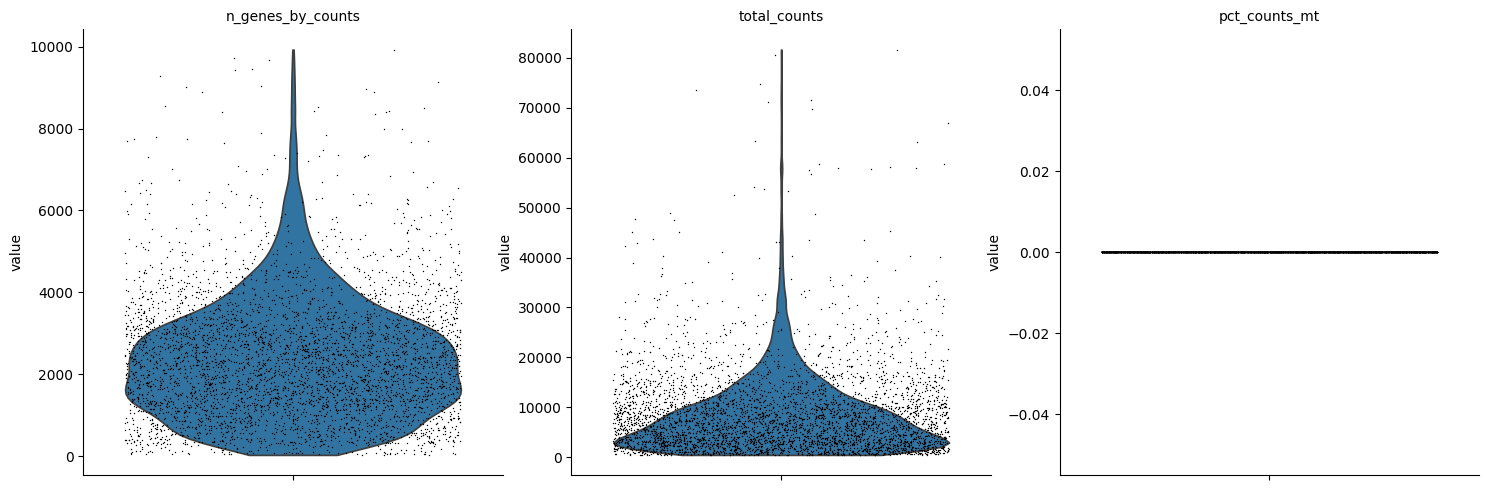

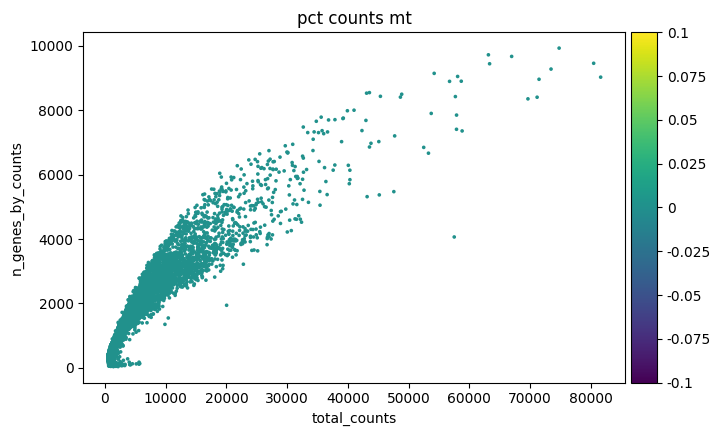

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


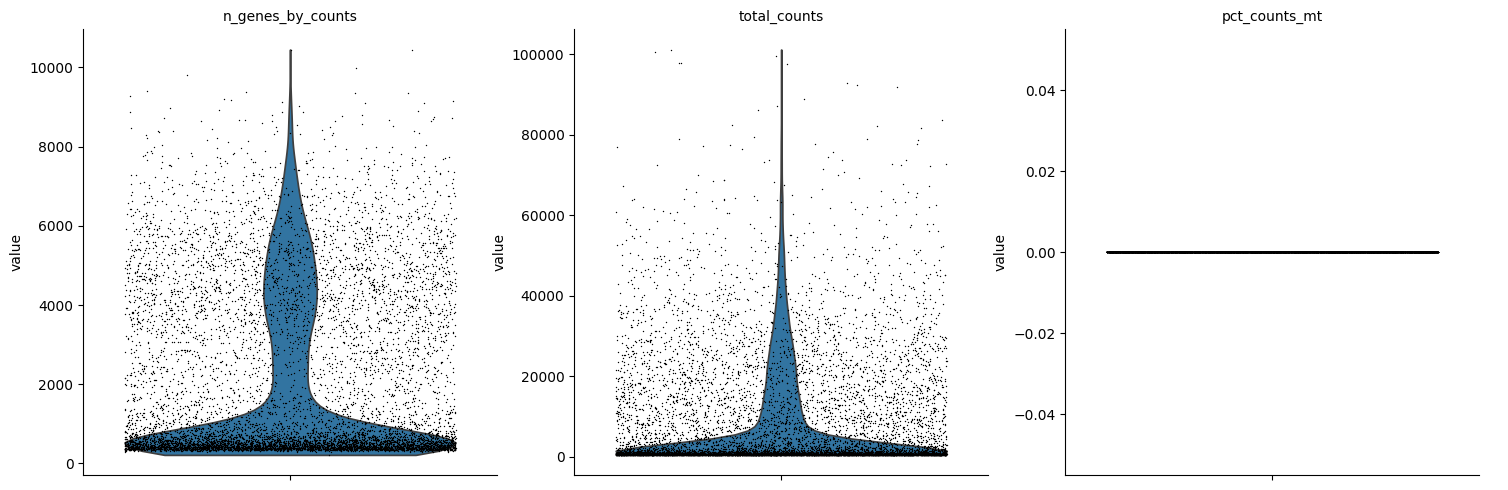

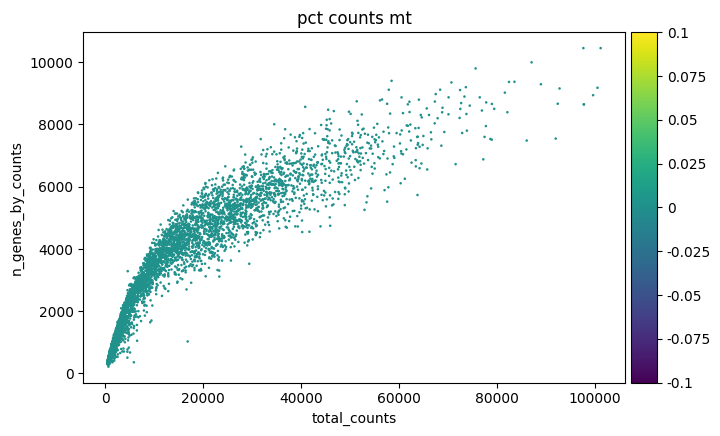

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


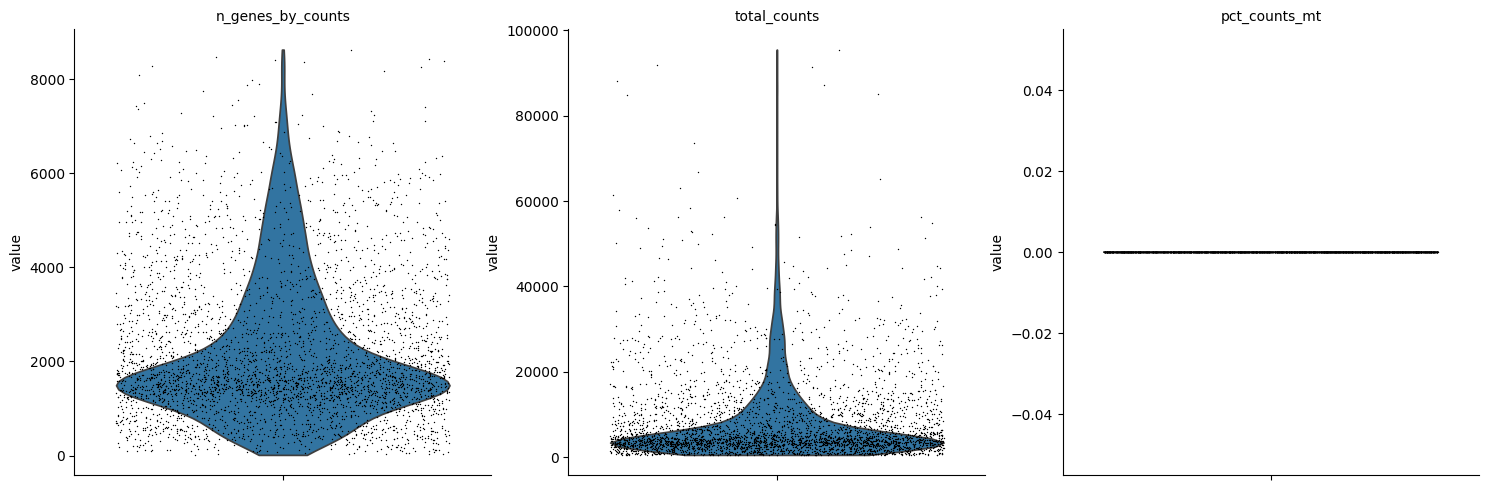

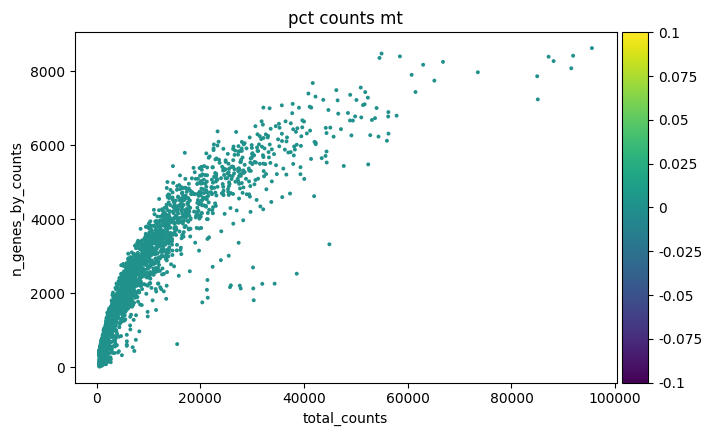

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


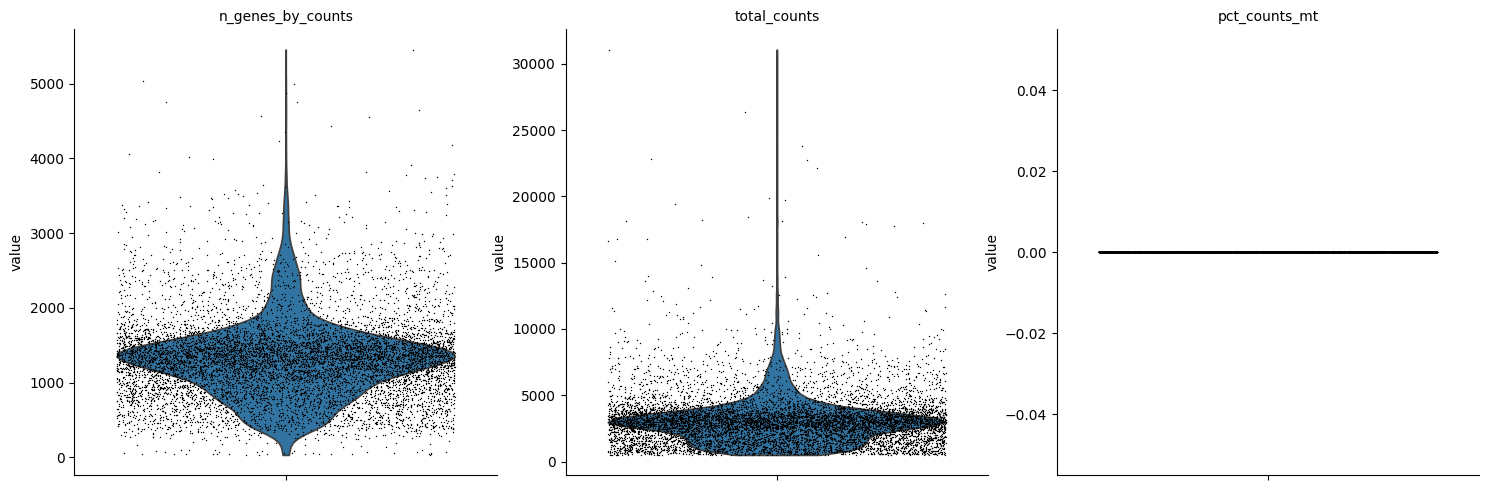

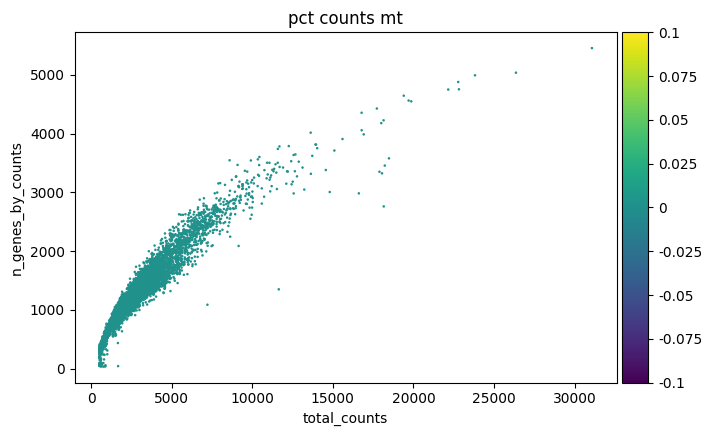

... storing 'SRX_accession' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_symbol' as categorical


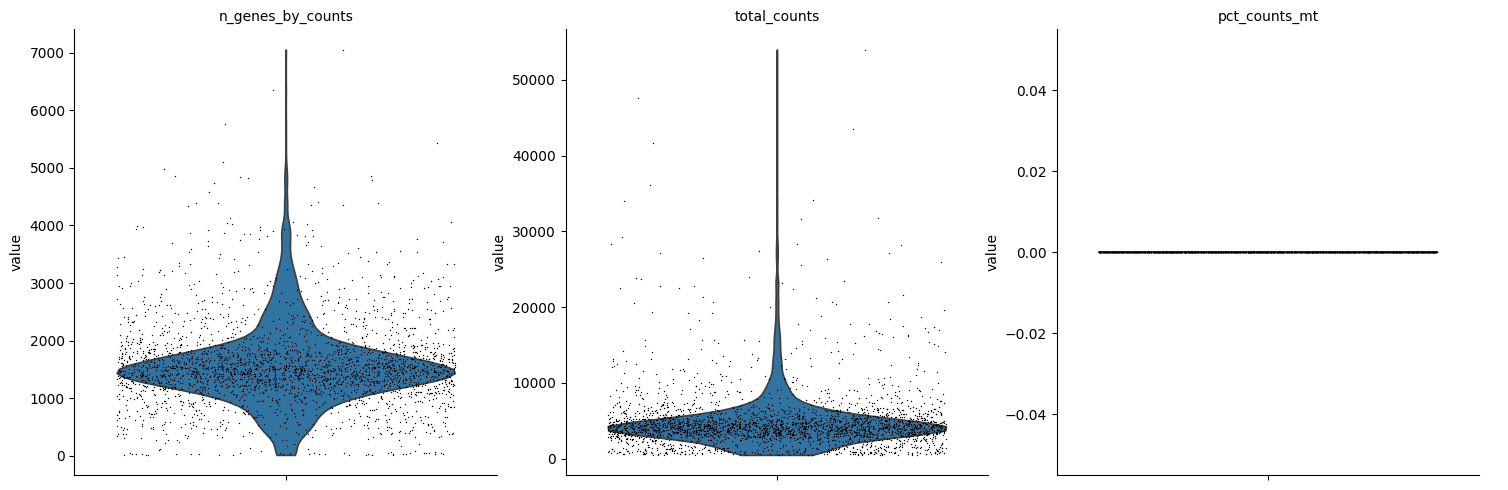

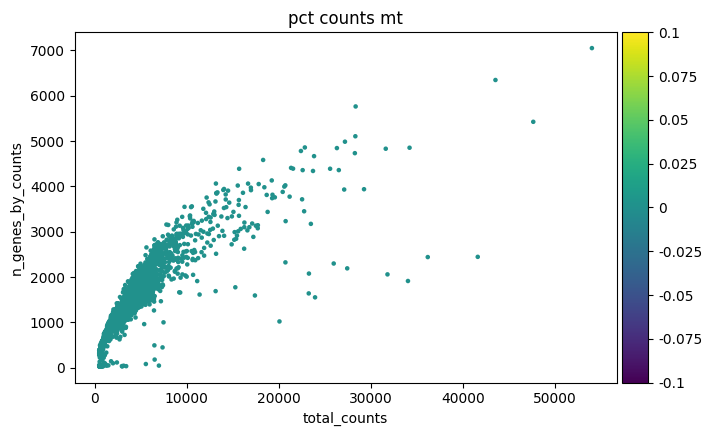

In [ ]:
for SRX_sample in adata.obs["SRX_accession"].unique():
    adata = adata_org[adata_org.obs["SRX_accession"] == SRX_sample].copy()
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
    )

    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )

    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")
    
    # Finally, do UMI comparisons

In [25]:
# sc.pp.scrublet(adata, batch_key="sample") # Batch key should be provided!

In [26]:
adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000274175', 'ENSG00000275869', 'ENSG00000273554',
       'ENSG00000278782', 'ENSG00000277761', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=36601)